In [5]:
import polars as pl
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
from math import floor
from datetime import datetime

In [6]:
LIMIT_AXLES_SAME_GROUP = 1.8
AXLE_WEIGHT = 'AxleWeight'
AXLE_DISTANCE = 'AxleDistance'
GROSS_WEIGHT = 'GrossWeight'
LIMIT_ESAL_VALUE = 10

def calculate_b_factor_and_esal(filepath: str) -> float:
    df = pl.read_csv(filepath, separator=';', truncate_ragged_lines=True, skip_rows=6)
    df = df.rename({col: col.replace(' ', '') for col in df.columns})
    df = df.filter(pl.col(GROSS_WEIGHT) > 3500)
    df = df.with_columns(
        pl.col("StartTime").cast(pl.Datetime(time_unit='ms')).alias('unix_timestamp')
    )

    earliest_date = df['unix_timestamp'].min()
    latest_date = df['unix_timestamp'].max()
    
    esal_values_individual_vehicles = calculate_esal(df)
    esal_values_individual_vehicles = esal_values_individual_vehicles[esal_values_individual_vehicles < LIMIT_ESAL_VALUE]
    n = len(esal_values_individual_vehicles)
    b_factor = np.sum(esal_values_individual_vehicles) / n

    return b_factor, esal_values_individual_vehicles, earliest_date, latest_date

def calculate_esal(df: pl.DataFrame) -> float:
    esal_values_individual_vehicles = np.array([])

    for row in df.iter_rows(named=True):
        weights, k_values = calculate_esal_individual(row)
        esal_values_individual_vehicles = np.append(esal_values_individual_vehicles, np.sum((weights / 10)**4 * k_values))

    return esal_values_individual_vehicles

def calculate_esal_individual(row: tuple) -> float:
    weights = np.array([])
    k_values = np.array([])

    axle = 1
    axles_in_group = 0
    weight_in_group = 0

    while f'{AXLE_DISTANCE}{axle}' in row and row[f'{AXLE_DISTANCE}{axle}'] != None:

        distance_from_previous_axle = float(row[f'{AXLE_DISTANCE}{axle}'])

        if distance_from_previous_axle <= LIMIT_AXLES_SAME_GROUP:
            axles_in_group += 1
            weight_in_group += (float(row[f'{AXLE_WEIGHT}{axle}']) / 1000)

        else:
            weights = np.append(weights, weight_in_group)
            k_values = np.append(k_values, k_value(axles_in_group))
            axles_in_group = 1
            weight_in_group = (float(row[f'{AXLE_WEIGHT}{axle}']) / 1000)

        axle += 1

    weights = np.append(weights, weight_in_group)
    k_values = np.append(k_values, k_value(axles_in_group))
        
    return weights, k_values

def k_value(axles: int) -> float:
    if axles == 1:
        return 1
    else:
        return (10 / (6 + 6 * axles))**4
    
def extract_location(filepath):
    if 'Aanestad' in filepath and ('Vest' in filepath or 'vest' in filepath):
        return 'Ånestad(vestgående)'
    if 'Aanestad' in filepath and ('Ost' in filepath or 'ost' in filepath or 'Øst' in filepath or 'øst' in filepath):
        return 'Ånestad(østgående)'
    if 'Øysand' in filepath:
        return 'Øysand'
    if 'Skibotn' in filepath:
        return 'Skibotn'
    if 'Verdal' in filepath:
        return 'Verdal'

In [7]:
datasets = (
    '../WIM-data/Kistler_Øysand/20160808-31_Kistler Øysand_4913151-export(1).csv',
    '../WIM-data/Kistler_Øysand/20160901-30_Kistler Øysand_4913151-export(2).csv',
    '../WIM-data/Kistler_Øysand/20161001-31_Kistler Øysand_4913151-export(3)-fixed.csv',
    '../WIM-data/Kistler_Øysand/20161101-30_Kistler Øysand_4913151-export(4).csv',
    '../WIM-data/Kistler_Øysand/20161201-31_Kistler Øysand_4913151-export(5).csv',
    '../WIM-data/Kistler_Øysand/20170101-31_Kistler Øysand_4913151-export(6).csv',
    '../WIM-data/Kistler_Øysand/20170201-28_Kistler Øysand_4913151-export(7).csv',
    '../WIM-data/Kistler_Øysand/20170301-31_Kistler Øysand_4913151-export(8).csv',
    '../WIM-data/Kistler_Øysand/20170401-05_Kistler Øysand_4913151-export(9)-fixed.csv',
    '../WIM-data/Kistler_Øysand/20180316_1.3.1_Kistler Øysand_4913151-export(24).csv',
    '../WIM-data/Kistler_Øysand/20180401-30_Kistler Øysand_4796227-export(12).csv',
    '../WIM-data/Kistler_Øysand/20180501-31(21-26)_Kistler Øysand_4796227-export(13).csv',
    '../WIM-data/Kistler_Øysand/20180601-30(11-30)_Kistler Øysand_4796227-export(14).csv',
    '../WIM-data/Kistler_Øysand/20180701-31(01-11)_Kistler Øysand_4796227-export(15).csv',
    '../WIM-data/Kistler_Øysand/20180801-31(10-31)_Kistler Øysand_4796227-export(16).csv',
    '../WIM-data/Kistler_Øysand/20180901-30_Kistler Øysand 4796227-export(17).csv',
    '../WIM-data/Kistler_Skibotn/combinedFiles_E8_2018_kalibrert_4okt.csv',
    '../WIM-data/Kistler_Skibotn/combinedFiles_E8_2019.csv',
    '../WIM-data/Kistler_Skibotn/combinedFiles_E8_2020.csv',
    '../WIM-data/Kistler_Verdal/20150513-20150531_Kistler Verdal 4796227.csv',
    '../WIM-data/Kistler_Verdal/20150601-20150630_Kistler Verdal 4796227.csv',
    '../WIM-data/Kistler_Verdal/20150701-20150731_Kistler Verdal 4796227.csv',
    '../WIM-data/Kistler_Verdal/20150801-20150831_Kistler Verdal 4796227.csv',
    '../WIM-data/Kistler_Verdal/20150901-20150930_Kistler Verdal 4796227.csv',
    '../WIM-data/Kistler_Verdal/20151001-20151031_Kistler Verdal 4796227.csv',
    '../WIM-data/Kistler_Verdal/20151101-20151130_Kistler Verdal 4796227.csv',
    '../WIM-data/Kistler_Verdal/20151201-20151231_Kistler Verdal 4796227.csv',
    '../WIM-data/Kistler_Verdal/20160101-20160131_Kistler Verdal 4796227.csv',
    '../WIM-data/Kistler_Verdal/20160201-20160229_Kistler Verdal 4796227.csv',
    '../WIM-data/Kistler_Verdal/20160301-20160331_Kistler Verdal 4796227.csv',
    '../WIM-data/Kistler_Verdal/20160401-20160430_Kistler Verdal 4796227.csv',
    '../WIM-data/Kistler_Verdal/20160501-20160531_Kistler Verdal 4796227.csv',
    '../WIM-data/Kistler_Aanestad/20221014-20 Kistler_R3_ostg.csv',
    '../WIM-data/Kistler_Aanestad/20221014-20 Kistler_R3_vestg.csv',
    '../WIM-data/Kistler_Aanestad/20240123-20240612_R3 østgående.csv',
    '../WIM-data/Kistler_Aanestad/20240122-20240612_R3 vestgående.csv',
    # '../WIM-data/Kistler_Aanestad/20231001-20240123_Aanestad_Ostgående.csv',
    # '../WIM-data/Kistler_Aanestad/20231001-20240123_Aanestad_Vestgående.csv'
)

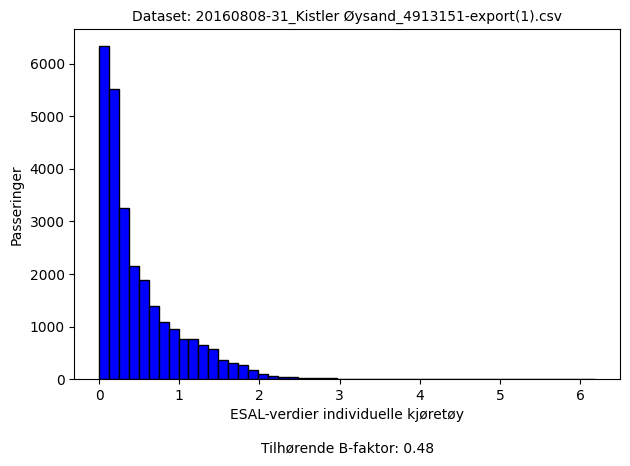

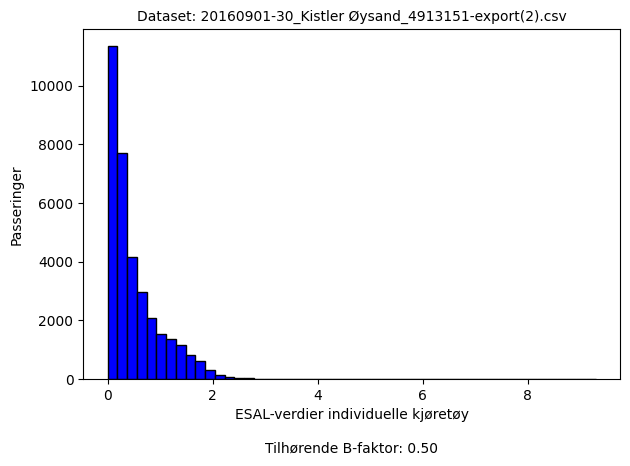

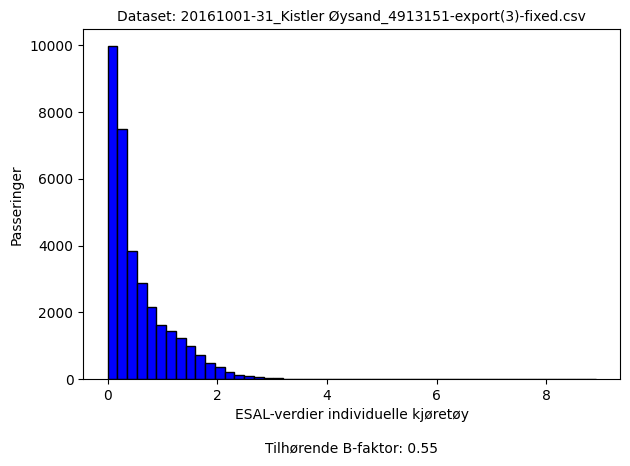

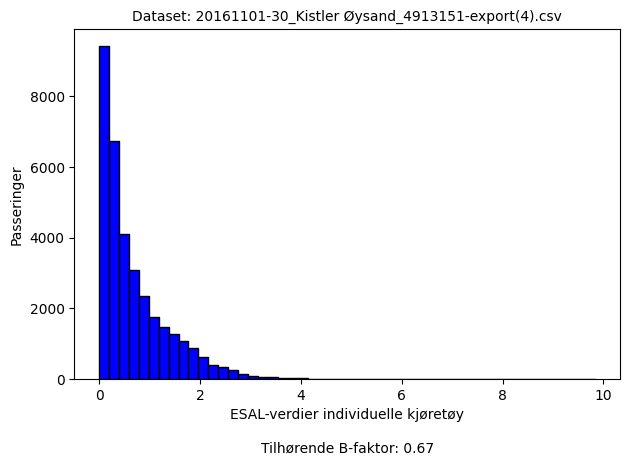

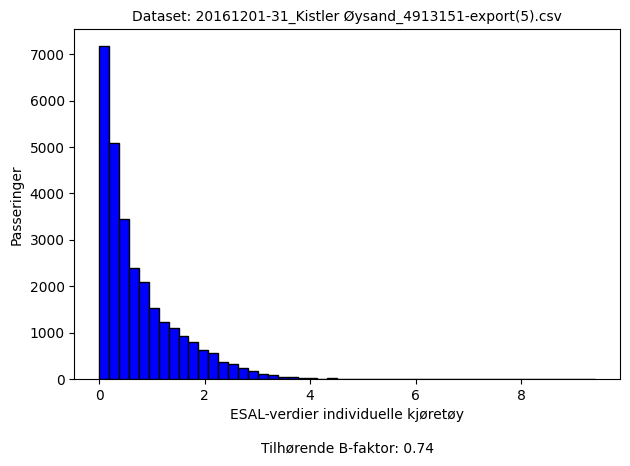

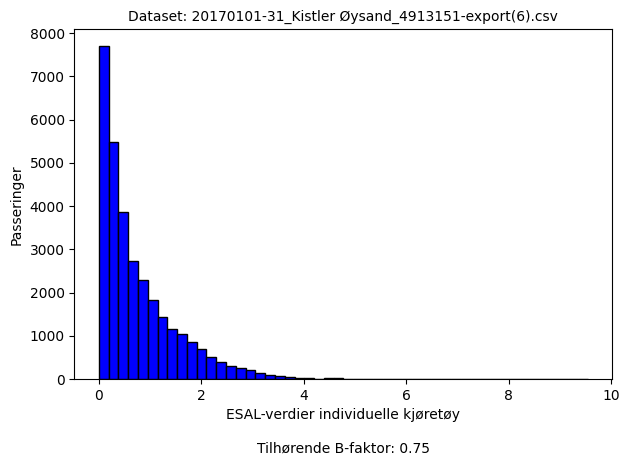

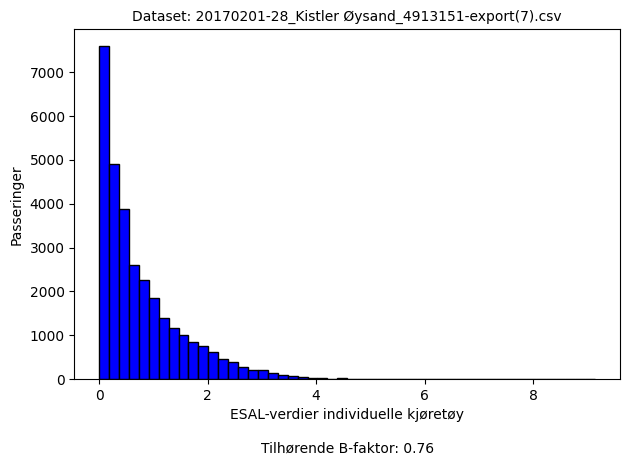

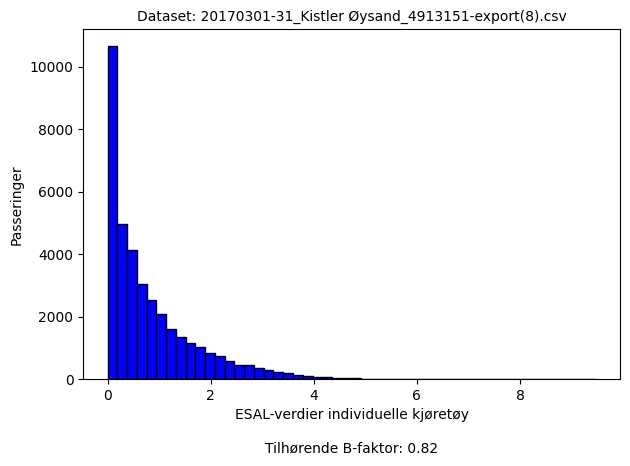

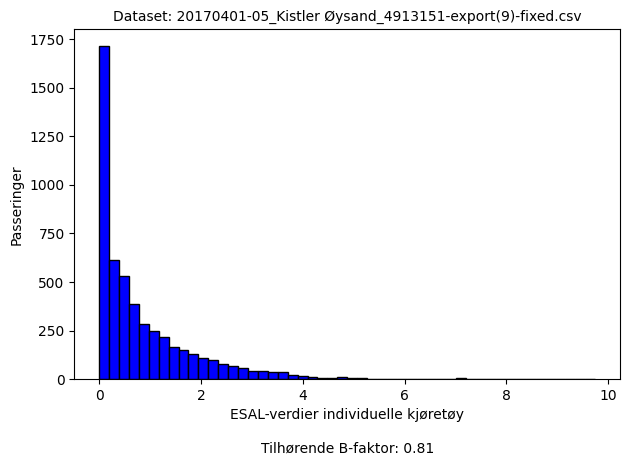

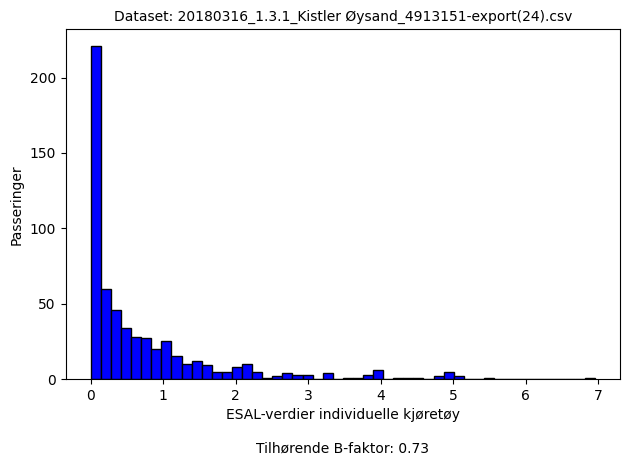

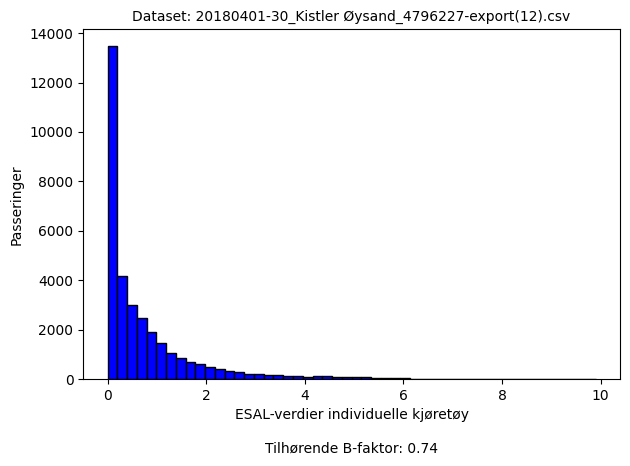

../WIM-data/Kistler_Øysand/20180501-31(21-26)_Kistler Øysand_4796227-export(13).csv


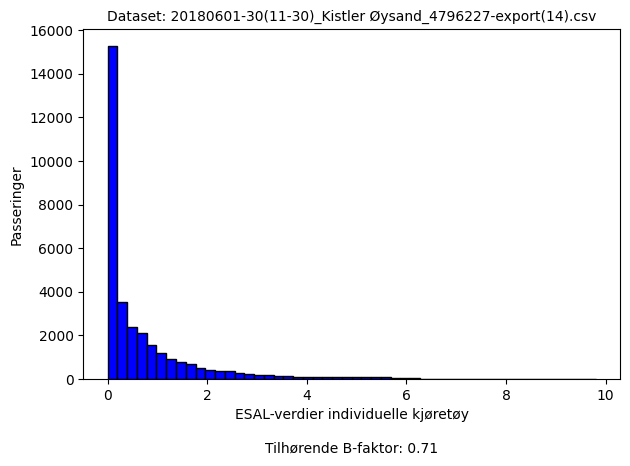

../WIM-data/Kistler_Øysand/20180701-31(01-11)_Kistler Øysand_4796227-export(15).csv


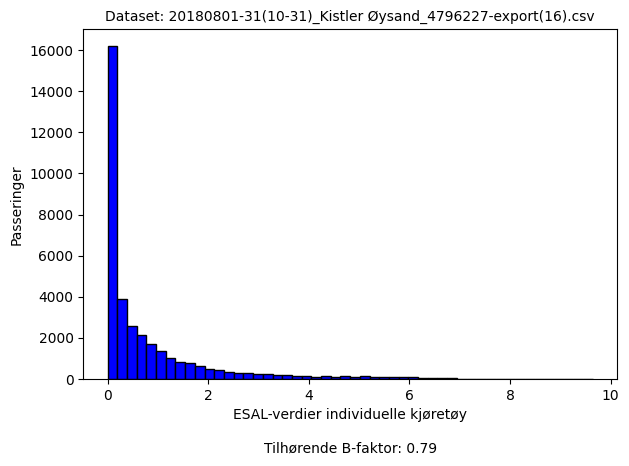

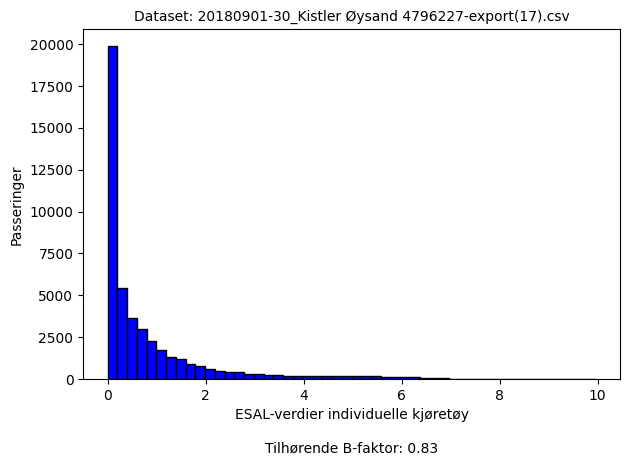

../WIM-data/Kistler_Skibotn/combinedFiles_E8_2018_kalibrert_4okt.csv
../WIM-data/Kistler_Skibotn/combinedFiles_E8_2019.csv


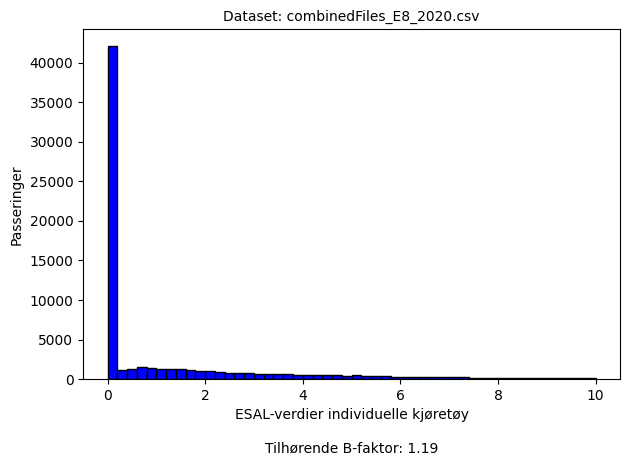

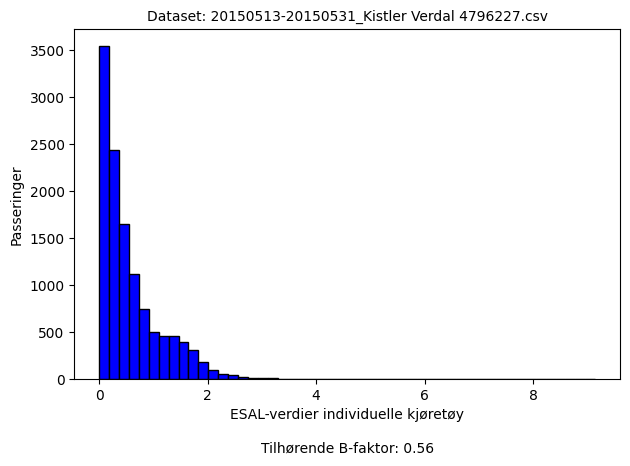

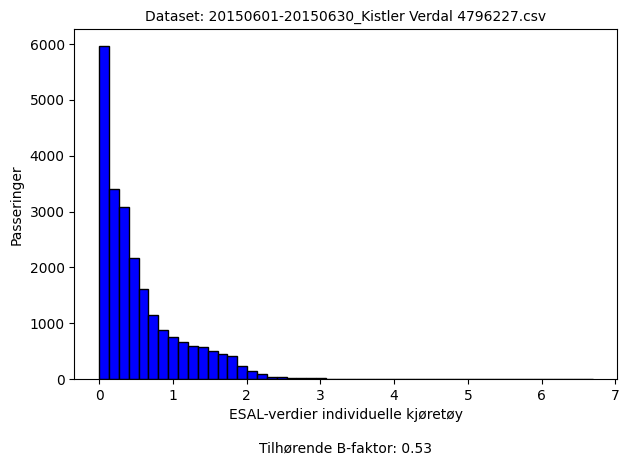

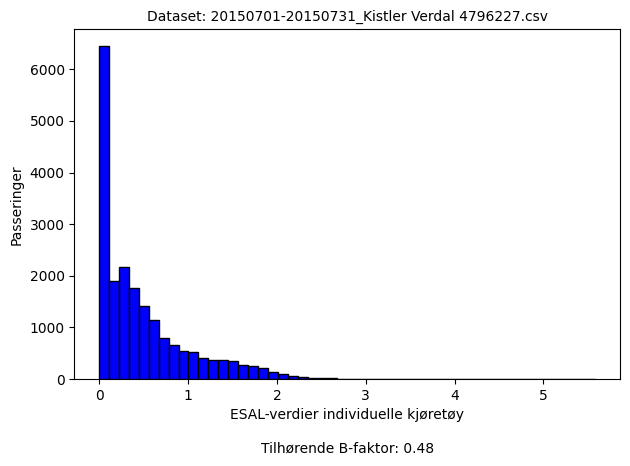

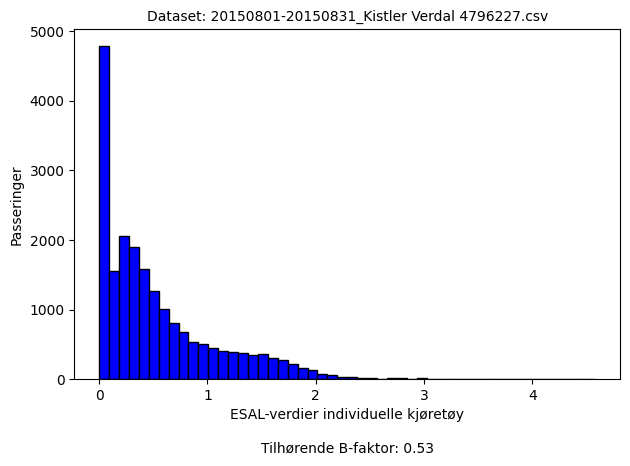

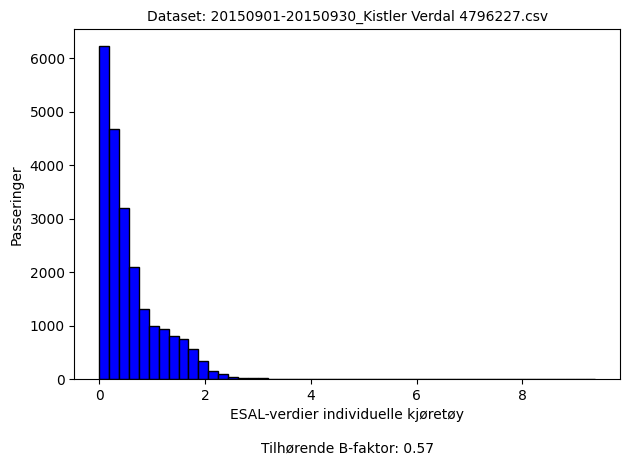

../WIM-data/Kistler_Verdal/20151001-20151031_Kistler Verdal 4796227.csv


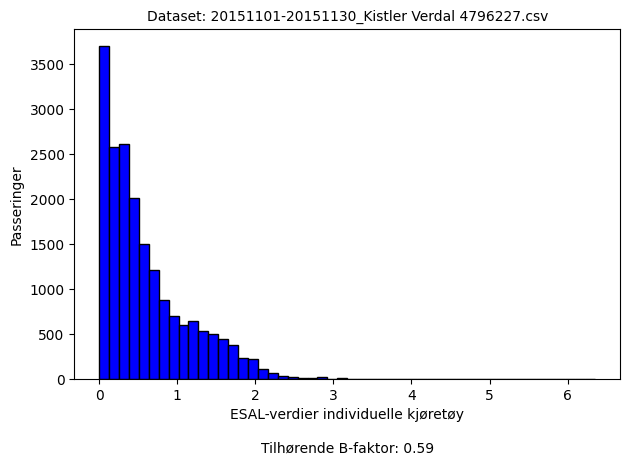

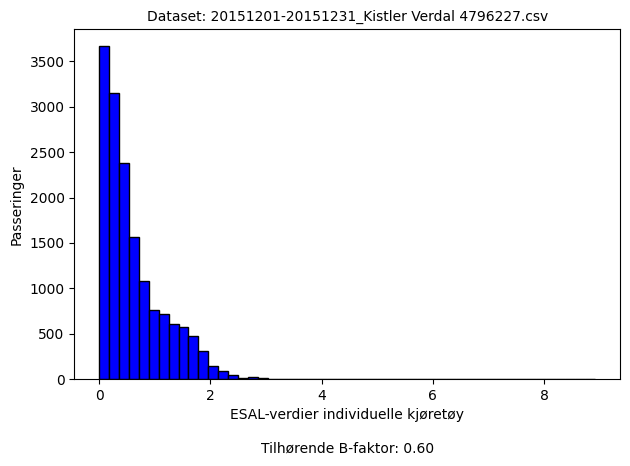

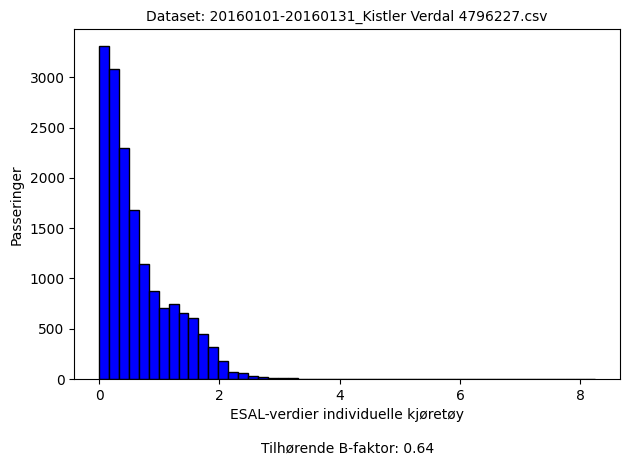

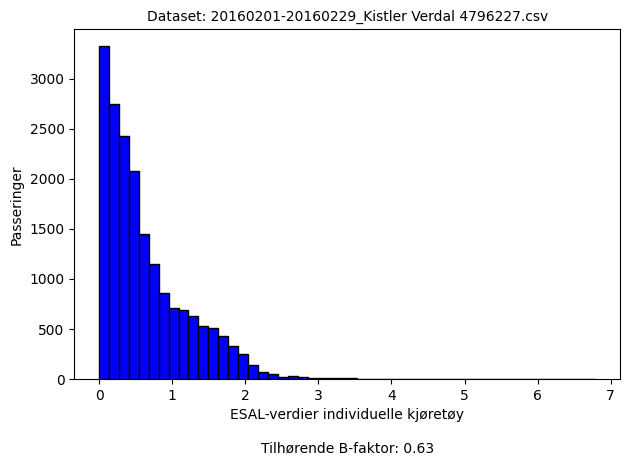

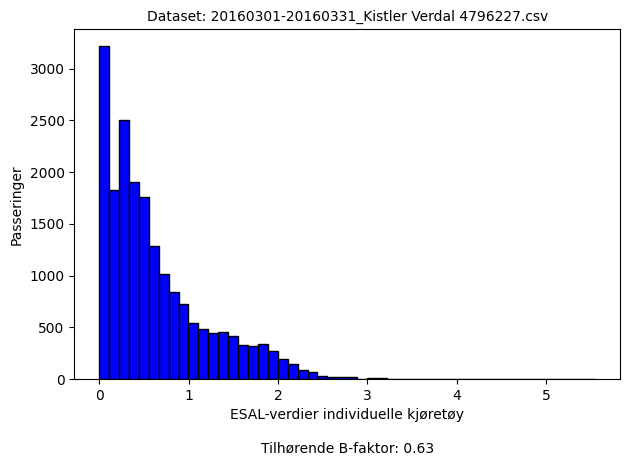

../WIM-data/Kistler_Verdal/20160401-20160430_Kistler Verdal 4796227.csv


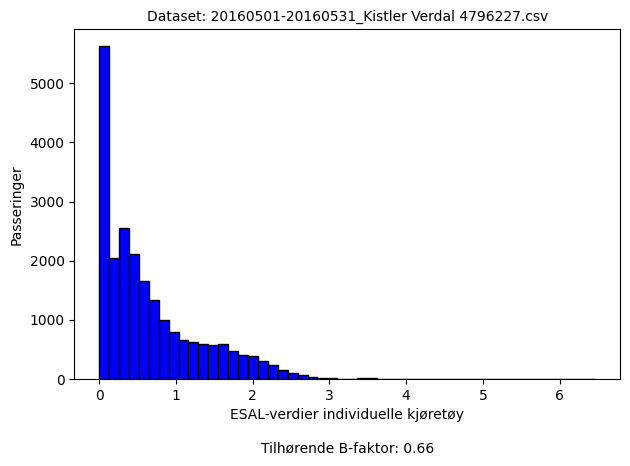

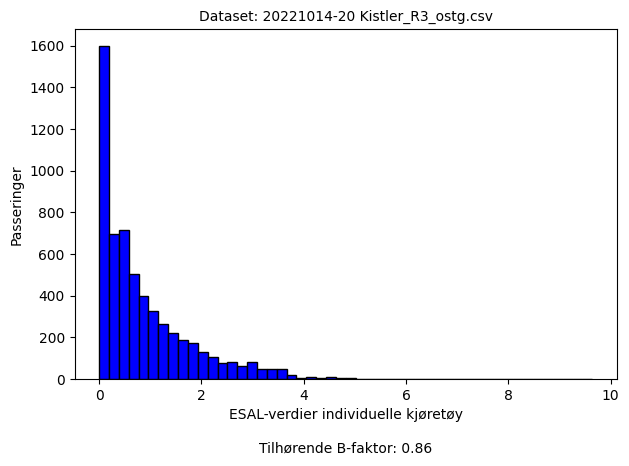

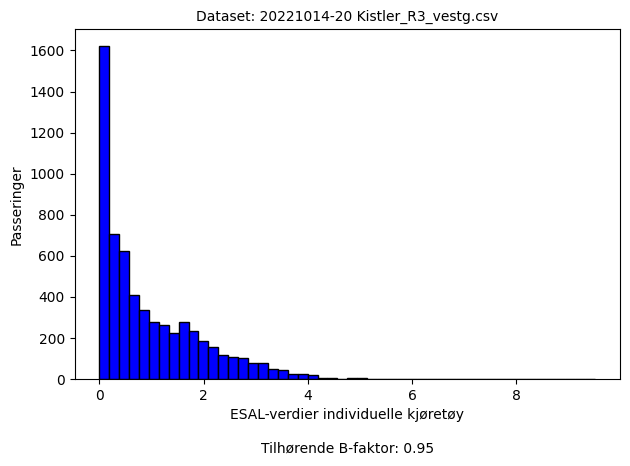

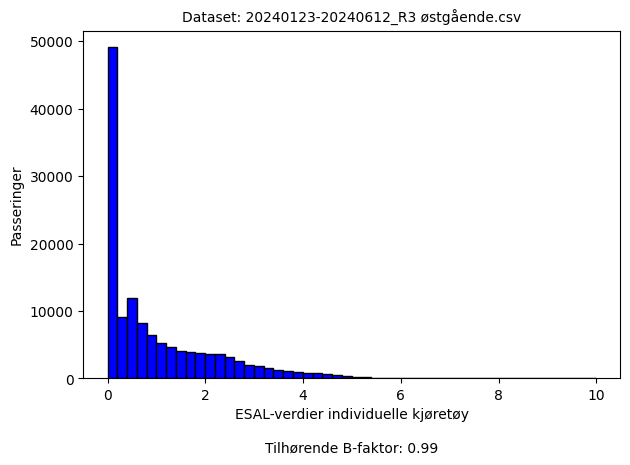

../WIM-data/Kistler_Aanestad/20240122-20240612_R3 vestgående.csv


In [8]:
intervals = np.linspace(0, 10, 51)
interval_labels = [f'{intervals[i]:.1f}-{intervals[i+1]:.1f}' for i in range(len(intervals)-1)]
cols = ['location', 'startdate', 'enddate', 'B-faktor'] + interval_labels
rows = []

for i, dataset in enumerate(datasets):
    try:
        location = extract_location(dataset)
        name_dataset = dataset.split('/')[-1] 
        b_factor, esal_values, startdate, enddate = calculate_b_factor_and_esal(dataset)
        startdate = startdate.date().isoformat()
        enddate = enddate.date().isoformat()

        plt.hist(esal_values, bins=50, color='blue', edgecolor='black')
        plt.xlabel('ESAL-verdier individuelle kjøretøy')
        plt.ylabel('Passeringer')
        plt.title(f'Dataset: {name_dataset}', fontsize=10)
        plt.text(0.5, -0.2, f'Tilhørende B-faktor: {b_factor:.2f}', ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)
        plt.tight_layout()
        plt.show()

        bins = [0] * 50
        for esal in esal_values:
            if esal >= LIMIT_ESAL_VALUE:
                continue
            bins[floor(esal / 10 * 49)] += 1
        rows.append([location, startdate, enddate, b_factor] + bins)

    except:
        print(dataset)

df = pl.DataFrame(schema=cols, data=rows)
df.write_csv('../resultater/b-faktor_kistler.csv')